In [1]:
from scipy import *
from numpy import *
from matplotlib import pyplot as plt
import os,sys

In [2]:
################################
########## PARAMETERS ##########

##------ General -------##

kT = 1.3806e-23 * 310. /1e-12/1e-6 # in pN.µm


##------ 10x 100sec-pull/release data -------##

dataPath_100s='../data/2-trajectory_files/100s-PR/'
fnTracking="20200304_100s-PR_trajectory.trk2"
fnFxyz="20200304_100s-PR_Fxyz.csv"

pixelSize=0.129 # um
dt=5 # sec
delaySwitchMagnet=dt-1 # Delay in sec between placement/removal of magnet and acquisition of image


##------ Display -------##

colors={'force':          '#f07100',
        'diffusion_fill': '#00000010',
        'pred':           '#606060',
        'unexpl':         '#000000',
        'lateral':        '#5480a6'}

cm_traj_100s=plt.cm.colors.LinearSegmentedColormap('cm_traj_100s',
    {'red':   ((0,.0,.0),(.5,.3,.3),(1,.6,.6)),
     'green': ((0,.3,.3),(.5,.6,.6),(1,.6,.6)),
     'blue':  ((0,.2,.2),(.5,.0,.0),(1,.1,.1))})

################################
################################

In [3]:
##------ Load 10x 100sec-pull/release data -------##

dataTracking=loadtxt(dataPath_100s+fnTracking)
# 0:frame  1:X  2:Y  3:Z   4:fluo  5:bg  6:bgTiltX  7:bgTiltY  8:bgTiltZ  9(bits: spot detected, fit convereged)

Fxyz=loadtxt(dataPath_100s+fnFxyz,skiprows=1,delimiter=';')[:600,1:] # in pN

# Time
t=dataTracking[:,0]*dt+delaySwitchMagnet

# Position
pos=dataTracking[:,1:3]*pixelSize*r_[1,-1]
pos-=pos[:20].mean(0) # Center on origin

# Frame index of each pull and each release
indPull   =where(diff((Fxyz[:,0]!=0)*1)==1)[0]+1
indRelease=where(diff((Fxyz[:,0]!=0)*1)==-1)[0]+1
tPull=indPull*dt; tRelease=indRelease*dt; 


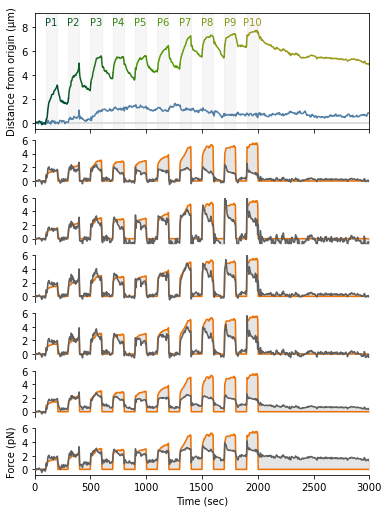

In [4]:
import sys; sys.path.append('./rouselib')
import rouselib

ix=1
lInfer=[]

#G=2*kT*0.158 # Measured from the slope of the force-displacement plot.
G = 0.001627 # Measured on 5-sec resolution traces taken before (n=11) and after (n=8) the 30'-PR experiments of 20210723

stepSizes=abs(pos[:,ix]-r_[pos[0,ix],pos[:-1,ix]]);

# Rouse (infinite)
if 1:
    forceRescaling = 1.0; # 1 means no rescaling, i.e. using independent passive MSD measurements
    infer=rouselib.locus.locusInference(t, pos, Gamma=G*forceRescaling); infer.populate(); lInfer.append(infer)
    infer.computeFdrag(density=stepSizes*0, mode=0, ix=ix);


### Interaction with surrounding chromatin ###

# Rouse + sticky chromatin, i.e. making permanent crosslinks with encountered chromatin
if 1:
    forceRescaling = 1.4;
    attachmentFactor = 0.077;  # Attachement of the locus in %/µm (The % is relative to the initial number of Rouse chains tethered at t=0)
    infer=rouselib.locus.locusInference(t, pos, Gamma=G*forceRescaling); infer.populate(); lInfer.append(infer)
    infer.computeFdrag(density=stepSizes*attachmentFactor, mode=0, ix=ix);

# Rouse + one-sided 'glove', i.e. pushing chromatin during pulls
if 1:
    forceRescaling = 1.0; # 1 means no rescaling, i.e. using independent passive MSD measurements
    attachmentFactor = 0.06; # Attachement of the locus in %/µm (The % is relative to the initial number of Rouse chains tethered at t=0)
    infer=rouselib.locus.locusInference(t, pos, Gamma=G*forceRescaling); infer.populate(); lInfer.append(infer)
    infer.computeFdrag(density=stepSizes*attachmentFactor, mode=2, ix=ix);

# Rouse + two-sided glove, i.e. pushing chromatin during pulls and releases
if 1:
    forceRescaling = 1.0; # 1 means no rescaling, i.e. using independent passive MSD measurements
    attachmentFactor = 0.072;  # Attachement of the locus in %/µm (The % is relative to the initial number of Rouse chains tethered at t=0)
    infer=rouselib.locus.locusInference(t, pos, Gamma=G*forceRescaling); infer.populate(); lInfer.append(infer)
    infer.computeFdrag(density=stepSizes*attachmentFactor, mode=1, ix=ix);

# mode= 0:sticky, 1:two-sided glove, 2:one-sided glove


### Properties off a gel-like material ###

# Rouse with viscoelastic solvent. i.e. Gel-like medium
if 1:
    forceRescaling = 1.8;
    alpha= 0.35;             # Viscoelastic exponent
    infer=rouselib.locus.locusInference(t, pos, Gamma=G*forceRescaling, alpha=alpha); infer.populate(); lInfer.append(infer)
    infer.computeFdrag(density=stepSizes*0, mode=0, ix=ix);

# Rouse with finite tether. i.e. as expected if part of an interconnected mesh  
if 1:
    forceRescaling = 1.;
    tR=10.;                  # Rouse time of finite tether
    infer=rouselib.locus.locusInference(t, pos, Gamma=G*forceRescaling, tR=tR); infer.populate(); lInfer.append(infer)
    infer.computeFdrag(density=stepSizes*0, mode=0, ix=ix);



fig,ax=plt.subplots(1+len(lInfer),1, sharex=True, figsize=(6,1.*(2.5+len(lInfer))), gridspec_kw={'height_ratios':[2.5]+[1]*len(lInfer)})
#plt.figure(figsize=(10,1.5))

plt.sca(ax[0])
plt.plot(t,pos[:,0],color=colors['lateral']) #,marker='o',markerSize=2.5)
#plt.scatter(t,pos[:,1],color=cm_traj_100s((t/t[indPull[-1]]).clip(0,1)))
for i in range(len(indPull)):
    if   i==0:             indRange=[0,indPull[i+1]+1]
    elif i<len(indPull)-1: indRange=[indPull[i],indPull[i+1]+1]
    else:                  indRange=[indPull[i],t.shape[0]]
    plt.plot(t[indRange[0]:indRange[1]],pos[indRange[0]:indRange[1],1],color=cm_traj_100s(i/9))
plt.ylabel("Distance from origin (µm)"); plt.ylim(-.5,9.2);
for i in r_[:tPull.shape[0]]: plt.axvspan(tPull[i],tRelease[i], zorder=0, alpha=.2, color='lightgray')
for i in r_[:tPull.shape[0]]: plt.text((tPull[i]+tRelease[i])/2,8.8,'P%d'%(i+1),color=cm_traj_100s(i/9),verticalalignment='top',horizontalalignment='center')
plt.axhline(0,c='lightgray',zorder=0)
#plt.grid();

for i,infer in enumerate(lInfer):
    plt.sca(ax[i+1])
    ax[i+1].spines['top'].set_visible(False); ax[i+1].spines['right'].set_visible(False)
    ax[i+1].spines['bottom'].set_visible(False); ax[i+1].tick_params(bottom=False)
    plt.yticks([0,2,4,6])

    fpoly = -infer.fpoly[:,ix]
    fdrag  = infer.fdrag[:,ix]
    fpoly_std = diag(infer.covForce())**.5

    plt.plot(t, -Fxyz[:,ix], label='Experimental force', color=colors['force'],  zorder=2)
    plt.plot(t, fpoly+fdrag, label='Predicted force',     color=colors['pred'],   zorder=5)
    plt.fill_between(t, fpoly+fdrag,
                -Fxyz[:,ix], label='Unexplained force', alpha=.1, color=colors['unexpl'], zorder=1)

    plt.ylim(-.8,6.);
    
ax[i+1].spines['bottom'].set_visible(True); ax[i+1].tick_params(bottom=True)
plt.xlabel('Time (sec)'); plt.xlim(0,3000);
plt.ylabel('Force (pN)');

#plt.show()
plt.savefig('fig3_inference.pdf')

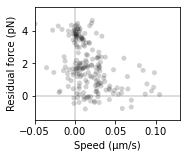

In [5]:
##### 
infer=lInfer[0] # Chose model

########################

fpoly = -infer.fpoly[:,ix]
fdrag  = infer.fdrag[:,ix]

Funexpl = (-Fxyz[:,1]) - (fpoly+fdrag)
speed=(infer.x[1:,1]-infer.x[:-1,1])/dt; speed=r_[speed,speed[-1]]

ptsPull = where(Fxyz[:,1] != 0)[0]
ptsRelease = where(Fxyz[:,1] == 0)[0]

plt.figure(figsize=[2.7,2.3])
plt.scatter(speed[ptsPull], Funexpl[ptsPull], edgecolor='none', facecolor=colors['unexpl'], s=25, alpha=.18)

plt.axhline(0,c='lightgray',zorder=0); plt.axvline(0,c='lightgray',zorder=0)
plt.xlim(-.05,.13);
plt.ylim(-1.5,5.5);
plt.xlabel('Speed (μm/s)'); plt.ylabel('Residual force (pN)')

plt.tight_layout()
#plt.show()
plt.savefig('fig3_inference_notViscosity.pdf')


Elasticity constant = 4.81 pN/µm
Energy barrier = 46.3 kT


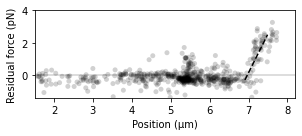

In [6]:
########################

infer=lInfer[2] # Chose model

########################

fpoly = -infer.fpoly[:,ix]
fdrag  = infer.fdrag[:,ix]

Funexpl = (-Fxyz[:,1]) - (fpoly+fdrag)

ptsPull = where(Fxyz[:,1] != 0)[0]
ptsRelease = where(Fxyz[:,1] == 0)[0]

plt.figure(figsize=[4.3,2])
plt.scatter(pos[ptsPull,1], Funexpl[ptsPull], edgecolor='none', facecolor=colors['unexpl'], s=25, alpha=.18)
plt.scatter(pos[ptsRelease,1], Funexpl[ptsRelease], edgecolor='none', facecolor=colors['unexpl'], s=25, alpha=.18)

# Compute elasticity constant at nuclear periphery
ptsPeriph=where((pos[:,1]>6.8) * (Fxyz[:,1]!=0))[0]
#plt.axvline(6.8,c='r',zorder=0)
slope=(lambda cov: cov[0,0]/cov[1,1])(cov(Funexpl[ptsPeriph],pos[ptsPeriph,1])**.5)
x0=mean(pos[ptsPeriph,1])-mean(Funexpl[ptsPeriph])/slope
print("Elasticity constant = %.2f pN/µm"%slope)
line=r_[-.3,2.5]; plt.plot(x0+line/slope, line, ls='--', color='k')
#plt.scatter(Funexpl[ptsPeriph], pos[ptsPeriph,1], edgecolor='none', facecolor='r', s=25, alpha=.18)

# Compute energy barrier
ptsBarrier=where((5.2<pos[:,1])*(pos[:,1]<5.7) * (Fxyz[:,1]!=0) * (Funexpl>.25))[0]
#plt.axvline(5.2,c='r',zorder=0); plt.axvline(5.7,c='r',zorder=0); 
width=2*var(pos[ptsBarrier,1])**.5; height=mean(Funexpl[ptsBarrier])+var(Funexpl[ptsBarrier])**.5
energyBarrier=width*height/kT
print("Energy barrier = %.1f kT"%energyBarrier)
#plt.scatter(Funexpl[ptsBarrier], pos[ptsBarrier,1], edgecolor='none', facecolor='r', s=25, alpha=.18)

plt.axhline(0,c='lightgray',zorder=0)
plt.xlim(1.5,8.2); plt.ylim(-1.4,4.);
plt.xlabel('Position (μm)'); plt.ylabel('Residual force (pN)')

plt.tight_layout()
#plt.show()
plt.savefig('fig3_inference_obstacles.pdf')
